In [12]:
import pandas as pd
import numpy as np
import os
from sklearn.neighbors import NearestCentroid


df = pd.read_csv('/home/martin/projects/hpa_image_analysis/data/colon_enhanced.csv')
df['tissue_type'] = df.apply(lambda row: row['s3_aws_urls'].split('/')[6], axis=1)
df['filename'] = df.apply(lambda row: row['s3_aws_urls'].split('/')[9], axis=1)

file_list = os.listdir('/data/hpa/colon/embeddings')
df['embedding'] = df.apply(lambda row: np.load('/data/hpa/colon/embeddings/{}.npy'.format(row['filename'].split('.')[0]))
                           if row['filename'].split('.')[0]+'.npy' in file_list else np.nan, axis=1)

In [13]:
df['tissue_type_binary'] = df.apply(lambda row: 1 if row['tissue_type']=='pathology_tissue' else 0, axis=1)

In [19]:
df = df.dropna(subset=['embedding'])
clf = NearestCentroid()
clf.fit(np.stack(df['embedding'].values), df['tissue_type_binary'])

NearestCentroid(metric='euclidean', shrink_threshold=None)

In [57]:
healthy_centroid = clf.centroids_[0]

In [73]:
grading_df.columns

Index(['antibody', 'antibody_hpa_literature_concordance',
       'antibody_icc_if_verification', 'antibody_ihc_verification',
       'antibody_proteinarray_verification',
       'antibody_westernblot_verification', 'cell_type', 'disease_type',
       'gene', 'healthy_status', 'hpa_patientID',
       'hpa_tissue_description_list', 'intensity', 'organ', 'quantity',
       's3_aws_url', 'snomedCode_List', 'staining', 'subcellular_location',
       'grading_status', 'filename', 'embedding', 'dist_from_norm'],
      dtype='object')

In [101]:
grading_df = pd.read_csv('../data/grading_test_set_annotated.csv')
grading_df['filename'] = grading_df.apply(lambda row: row['s3_aws_url'].split('/')[9], axis=1)
grading_df['embedding'] = grading_df.apply(lambda row: np.load('/data/hpa/colon/embeddings/{}.npy'.format(row['filename'].split('.')[0]))
                           if row['filename'].split('.')[0]+'.npy' in file_list else np.nan, axis=1)
grading_df = grading_df.dropna(subset=['embedding'])
grading_df['dist_from_norm'] = grading_df.apply(lambda row: cdist(row['embedding'].reshape(1, -1), healthy_centroid.reshape(1, -1))[0][0], axis=1)

In [85]:
grading_df.groupby('grading_status').median()['dist_from_norm']

grading_status
grading-moderate-diff    0.109216
grading-poor-diff        0.144115
grading-well-diff        0.109061
Name: dist_from_norm, dtype: float64

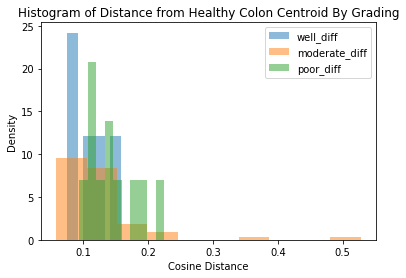

In [133]:
import matplotlib.pyplot as plt
plt.hist(grading_df[grading_df['grading_status']=='grading-well-diff']['dist_from_norm'], alpha=0.5, label='well_diff', density=True)

plt.hist(grading_df[grading_df['grading_status']=='grading-moderate-diff']['dist_from_norm'], alpha=0.5, label='moderate_diff', density=True)
plt.hist(grading_df[grading_df['grading_status']=='grading-poor-diff']['dist_from_norm'], alpha=0.5, label='poor_diff', density=True)
plt.legend()
plt.title('Histogram of Distance from Healthy Colon Centroid By Grading')
plt.xlabel('Cosine Distance')
plt.ylabel('Density')
plt.show()

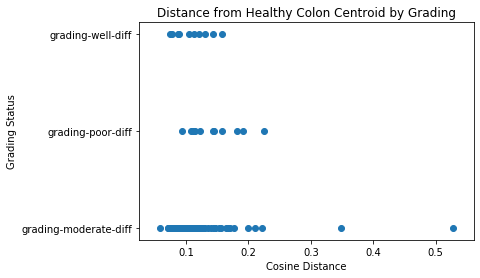

In [134]:
plt.scatter(grading_df['dist_from_norm'], grading_df['grading_status'])
plt.title('Distance from Healthy Colon Centroid by Grading')
plt.ylabel('Grading Status')
plt.xlabel('Cosine Distance')
plt.show()

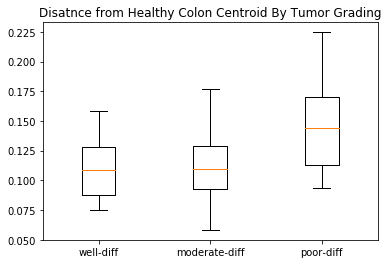

In [197]:
plt.boxplot([grading_df[grading_df['grading_status']=='grading-well-diff']['dist_from_norm'],
            grading_df[grading_df['grading_status']=='grading-moderate-diff']['dist_from_norm'],
            grading_df[grading_df['grading_status']=='grading-poor-diff']['dist_from_norm']],
           labels=['well-diff', 'moderate-diff', 'poor-diff'],
           showfliers=False)

plt.title('Disatnce from Healthy Colon Centroid By Tumor Grading')
plt.show()

In [124]:
tsne_df = pd.read_csv('colon_all_tsne_df.csv').rename(columns={'s3_aws_urls':'s3_aws_url'})
tsne_df.columns

Index(['tsne0', 'tsne1', 'tissue_type', 'filename', 's3_aws_url',
       'subcellular_location'],
      dtype='object')

In [125]:
tsne_df = tsne_df.merge(grading_df[['s3_aws_url', 'grading_status', 'filename']], on='s3_aws_url', how='left')

In [126]:
tsne_df.head()

,tsne0,tsne1,tissue_type,filename_x,s3_aws_url,subcellular_location,grading_status,filename_y
0,-51.386646,29.599413,pathology_tissue,61076_A_3_7.jpg,https://krzysztof-images.s3.amazonaws.com/hpa_...,none,NaN,NaN
1,-20.694557,0.871220,pathology_tissue,162650_A_3_7.jpg,https://krzysztof-images.s3.amazonaws.com/hpa_...,none,NaN,NaN
2,-38.931942,44.691277,pathology_tissue,117687_A_1_3.jpg,https://krzysztof-images.s3.amazonaws.com/hpa_...,"cytoplasmic/membranous,nuclear",NaN,NaN
3,24.746374,19.798674,pathology_tissue,80053_A_2_5.jpg,https://krzysztof-images.s3.amazonaws.com/hpa_...,cytoplasmic/membranous,NaN,NaN
4,32.392666,-36.240112,pathology_tissue,10158_A_1_4.jpg,https://krzysztof-images.s3.amazonaws.com/hpa_...,none,NaN,NaN


In [138]:
from scipy.stats import f_oneway, ttest_ind
f_oneway(grading_df[grading_df['grading_status'].isin(['grading-moderate-diff','grading-well-diff'])]['dist_from_norm'],
        grading_df[grading_df['grading_status']=='grading-poor-diff']['dist_from_norm'])

F_onewayResult(statistic=1.4864908438160063, pvalue=0.2259475148617701)

In [140]:
ttest_ind(grading_df[grading_df['grading_status']=='grading-poor-diff']['dist_from_norm'],
         grading_df[grading_df['grading_status'].isin(['grading-well-diff'])]['dist_from_norm'])

Ttest_indResult(statistic=2.27069251076444, pvalue=0.03498749699513416)

In [142]:
ttest_ind(grading_df[grading_df['grading_status']=='grading-well-diff']['dist_from_norm'],
         grading_df[grading_df['grading_status'].isin(['grading-moderate-diff'])]['dist_from_norm'])

Ttest_indResult(statistic=-0.6420174393828251, pvalue=0.5227205132531898)

In [143]:
ttest_ind(grading_df[grading_df['grading_status']=='grading-poor-diff']['dist_from_norm'],
         grading_df[grading_df['grading_status'].isin(['grading-moderate-diff'])]['dist_from_norm'])

Ttest_indResult(statistic=1.0740390401360385, pvalue=0.28603408547992115)

In [148]:
from sklearn.decomposition import PCA

model = PCA(n_components=2)
model.fit(np.stack(df['embedding'].head(10000)))
pca_output = model.transform(np.stack(df['embedding']))


In [152]:
output_df = pd.DataFrame(pca_output, columns=['comp0', 'comp1'])
output_df = pd.concat([output_df, df[['tissue_type', 'filename', 's3_aws_urls', 'subcellular_location']].reset_index()], axis=1).drop(columns='index')
output_df.head()

,comp0,comp1,tissue_type,filename,s3_aws_urls,subcellular_location
0,0.233934,-1.563479,pathology_tissue,134012_A_2_5.jpg,https://krzysztof-images.s3.amazonaws.com/hpa_...,"cytoplasmic/membranous,nuclear"
1,3.142037,-1.757334,pathology_tissue,134012_A_2_3.jpg,https://krzysztof-images.s3.amazonaws.com/hpa_...,none
2,2.523164,-4.826146,pathology_tissue,134012_A_2_8.jpg,https://krzysztof-images.s3.amazonaws.com/hpa_...,none
3,1.700623,1.890081,pathology_tissue,134012_A_1_1.jpg,https://krzysztof-images.s3.amazonaws.com/hpa_...,none
4,2.839025,-2.886092,pathology_tissue,134012_A_3_1.jpg,https://krzysztof-images.s3.amazonaws.com/hpa_...,none


In [153]:
output_df = output_df.rename(columns={'s3_aws_urls':'s3_aws_url'})
output_df = output_df.merge(grading_df, on='s3_aws_url', how='left')
len(output_df)

74849

In [154]:
output_df.head()

,comp0,comp1,tissue_type,filename_x,s3_aws_url,subcellular_location_x,antibody,antibody_hpa_literature_concordance,antibody_icc_if_verification,antibody_ihc_verification,...,intensity,organ,quantity,snomedCode_List,staining,subcellular_location_y,grading_status,filename_y,embedding,dist_from_norm
0,0.233934,-1.563479,pathology_tissue,134012_A_2_5.jpg,https://krzysztof-images.s3.amazonaws.com/hpa_...,"cytoplasmic/membranous,nuclear",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3.142037,-1.757334,pathology_tissue,134012_A_2_3.jpg,https://krzysztof-images.s3.amazonaws.com/hpa_...,none,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.523164,-4.826146,pathology_tissue,134012_A_2_8.jpg,https://krzysztof-images.s3.amazonaws.com/hpa_...,none,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.700623,1.890081,pathology_tissue,134012_A_1_1.jpg,https://krzysztof-images.s3.amazonaws.com/hpa_...,none,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2.839025,-2.886092,pathology_tissue,134012_A_3_1.jpg,https://krzysztof-images.s3.amazonaws.com/hpa_...,none,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [157]:
output_df['grading_status'] = output_df['grading_status'].fillna('none')

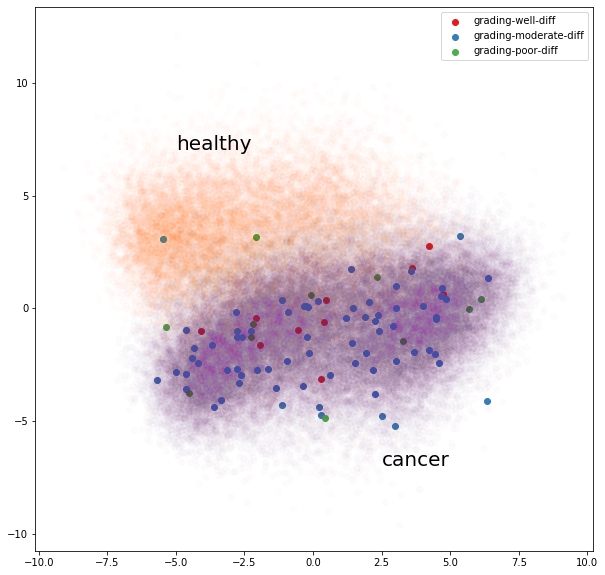

In [189]:
cmap = plt.get_cmap('Set1')
colors = cmap(np.linspace(0, 1, 10))

plt.figure(figsize=(10,10))

plt.scatter(output_df[output_df['grading_status']=='grading-well-diff']['comp0'], output_df[output_df['grading_status']=='grading-well-diff']['comp1'], label='grading-well-diff', c=[colors[0]], alpha=1)
plt.scatter(output_df[output_df['grading_status']=='grading-moderate-diff']['comp0'], output_df[output_df['grading_status']=='grading-moderate-diff']['comp1'], label='grading-moderate-diff', c=[colors[1]], alpha=1)
plt.scatter(output_df[output_df['grading_status']=='grading-poor-diff']['comp0'], output_df[output_df['grading_status']=='grading-poor-diff']['comp1'], label='grading-poor-diff', c=[colors[2]], alpha=1)
plt.scatter(output_df[output_df['tissue_type']=='pathology_tissue']['comp0'], output_df[output_df['tissue_type']=='pathology_tissue']['comp1'], c=[colors[3]], alpha=0.01)
plt.scatter(output_df[output_df['tissue_type']=='healthy_tissue']['comp0'], output_df[output_df['tissue_type']=='healthy_tissue']['comp1'], c=[colors[4]], alpha=0.01)
plt.text(2.5, -7, 'cancer', fontsize=20)
plt.text(-5, 7, 'healthy', fontsize=20)

plt.legend()
plt.show()